## Imports

In [1]:
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [2]:
# set seed to a fixed number to avoid stochasticity
SEED = 1312
np.random.seed(SEED)
random.seed(SEED)

## Dataset Loading

In [17]:
# Path to dataset: structured as /dataset/{genre}/*.wav
DATASET_PATH = Path("data/ELECTRONIC_MUSIC_V2")
GENRES = ["House", "Techno"]

In [18]:
# Storage
filepaths = []
durations = []
sr_list = []
genre_list = []

# Basic Stats: Duration, Sampling Rate
for genre in GENRES:
    genre_path = DATASET_PATH / genre
    for audio_file in genre_path.glob("*.wav"):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            filepaths.append(audio_file)
            durations.append(duration)
            sr_list.append(sr)
            genre_list.append(genre)
        except Exception as e:
            print(f"Failed to load {audio_file}: {e}")

# Create DataFrame
electronic_tracks_df = pd.DataFrame({
    "filepath": filepaths,
    "genre": genre_list,
    "duration_sec": durations,
    "sampling_rate": sr_list
})

electronic_tracks_df.head()

filepath  genre  duration_sec  \
0  data/ELECTRONIC_MUSIC_V2/House/Electronic musi...  House          10.0   
1  data/ELECTRONIC_MUSIC_V2/House/Music of Africa...  House          10.0   
2  data/ELECTRONIC_MUSIC_V2/House/House music, Mu...  House          10.0   
3  data/ELECTRONIC_MUSIC_V2/House/House music, Mu...  House          10.0   
4  data/ELECTRONIC_MUSIC_V2/House/Sampler, House ...  House          10.0   

   sampling_rate  
0          16000  
1          16000  
2          16000  
3          16000  
4          16000

In [19]:
electronic_tracks_df.iloc[:, 1:].value_counts()

genre   duration_sec  sampling_rate
House   10.0          16000            39
Techno  10.0          16000            29
Name: count, dtype: int64

In [20]:
# A good number for the frame length at 16K is 2048 (Also 4096 selected, yielded worst resutls)
FRAME_LENGTH = 2048
HOP_LENGTH = FRAME_LENGTH // 4

FRAME_LENGTH, HOP_LENGTH

(2048, 512)

### Basic Triplets: (Audible Signal, Audio Waveform, Spectrogram at dBs)

Plotting representative example for genre: House
data/ELECTRONIC_MUSIC_V2/House/House music, Music, Dance music, Electronica_YTJfrKunnD0_30.wav


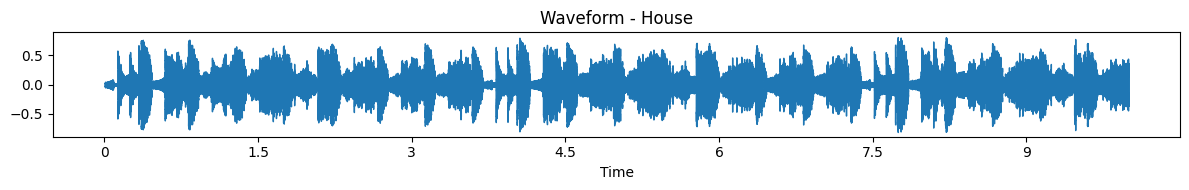

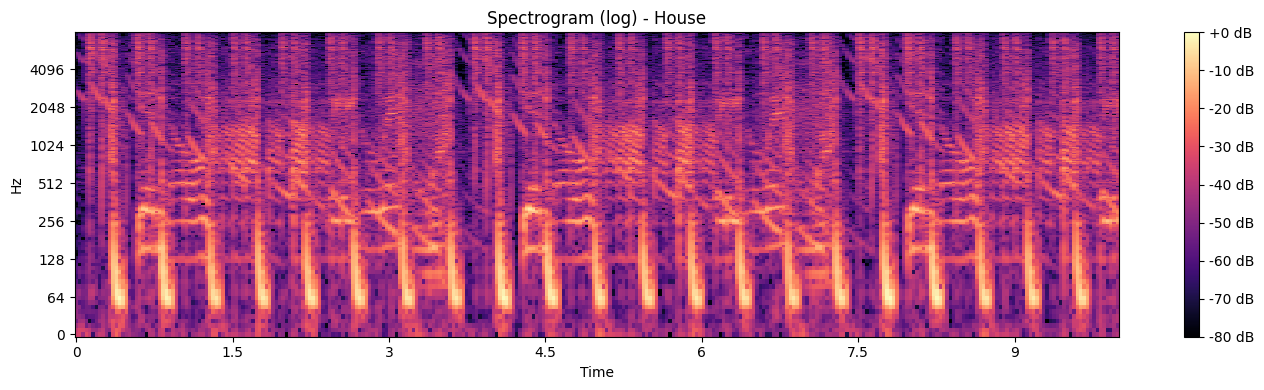

Plotting representative example for genre: Techno
data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_Vd8bmZtWPkQ_30.wav


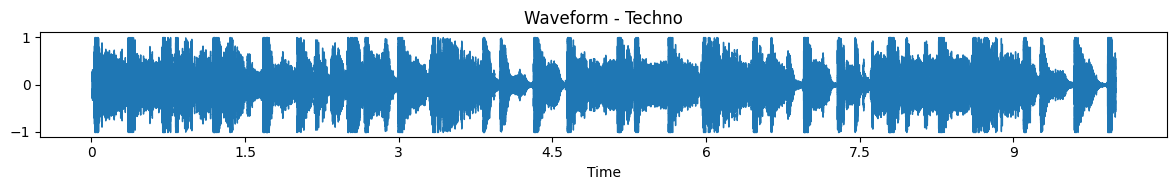

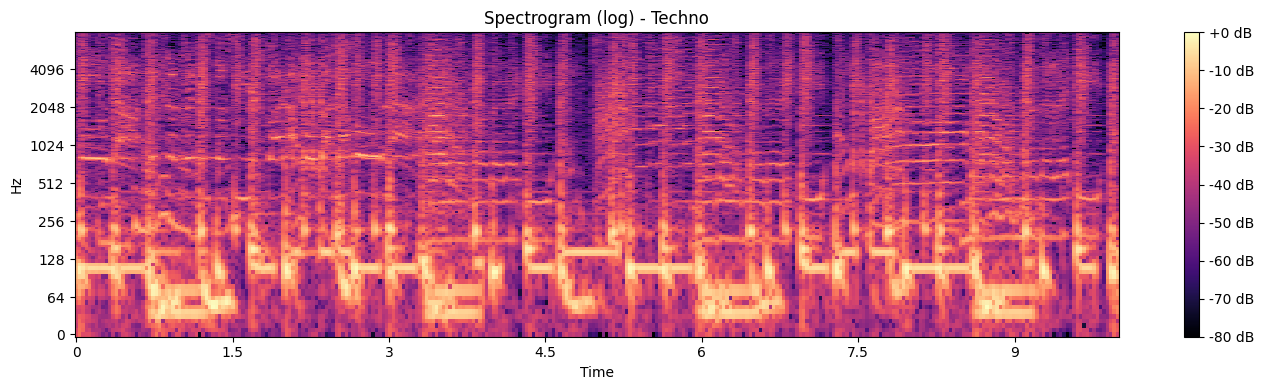

In [21]:
# Mean Waveform & Spectrogram Per Genre
for genre in GENRES:
    print(f"Plotting representative example for genre: {genre}")
    example_path = electronic_tracks_df[electronic_tracks_df["genre"] == genre]["filepath"].sample(1).values[0]
    print(example_path)
    y, sr = librosa.load(example_path, sr=None)

    # Audio sound
    ipd.display(ipd.Audio(y, rate=sr))

    # Waveform
    plt.figure(figsize=(12, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {genre}")
    plt.tight_layout()
    plt.show()

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)), ref=np.max)
    plt.figure(figsize=(14, 4))
    librosa.display.specshow(D, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram (log) - {genre}")
    plt.tight_layout()
    plt.show()

### Load Signals and Extract Selected Features based on the dict

In [22]:
from utils import extract_features

In [23]:
feature_flags = {
    "zcr": True,
    "centroid": True,
    "onset_strength": True,
    "mfcc": True,
    "chroma": True,
    "spectral_bandwidth": True,
    "spectral_rolloff": True,
    "rms": True,
    "spectral_contrast": False,
    "tempogram": False,
    "tonnetz": False,
    "mel_spectrogram": False,
}

DURATION = 10

In [24]:
X = []
y = []

for fp, label in zip(electronic_tracks_df["filepath"], electronic_tracks_df["genre"]):
    try:
        audio, sr = librosa.load(fp, sr=None)
        _x = extract_features(
            filepath=fp, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, segment_duration=DURATION, selected_features=feature_flags
        )
        
        X.append(_x)
        y.append(label)
    except Exception as e:
        print(f"Failed on {fp}: {e}")

X_segments = np.stack(X)  # shape: (samples, time_steps, features)
y_segments = np.array(y)  # shape: (samples,)

X_segments.shape, y_segments.shape

((68, 1, 313, 31), (68,))

### Treat each segment as an input instance

In [25]:
X = X_segments.reshape(-1, X_segments.shape[2], X_segments.shape[3])
X.shape

(68, 313, 31)

## Basic Exploratory Data Analysis (EDA)

### Class Count

Text(0, 0.5, 'Number of Samples')

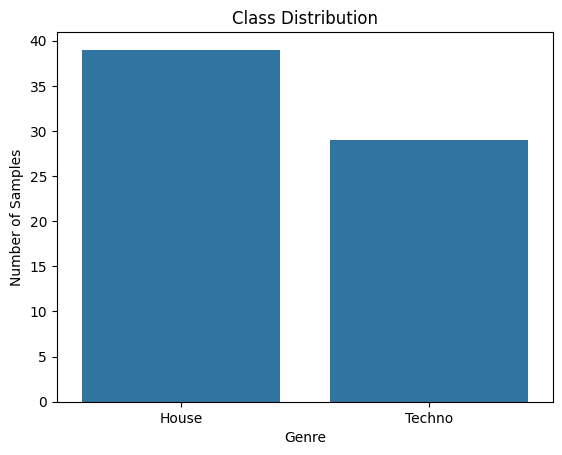

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Samples")

In [27]:
from utils import get_feature_names

In [28]:
# Flatten X: (n_instances, frames, features) → (n_instances * frames, features)
X_flat_time = X.reshape(-1, X.shape[2])
print(X_flat_time.shape)

# Repeat y values x times each to align with flattened X
y_repeated = np.repeat(y_segments, X.shape[1])

# Define feature names
features_names = get_feature_names(feature_flags=feature_flags)

# Create DataFrame
df_flat_time_features = pd.DataFrame(X_flat_time, columns=features_names)
df_flat_time_features['label'] = y_repeated

(21284, 31)


### Since all tracks are equal length, we can flatten the instances dimenensions and check distributions sample by sample

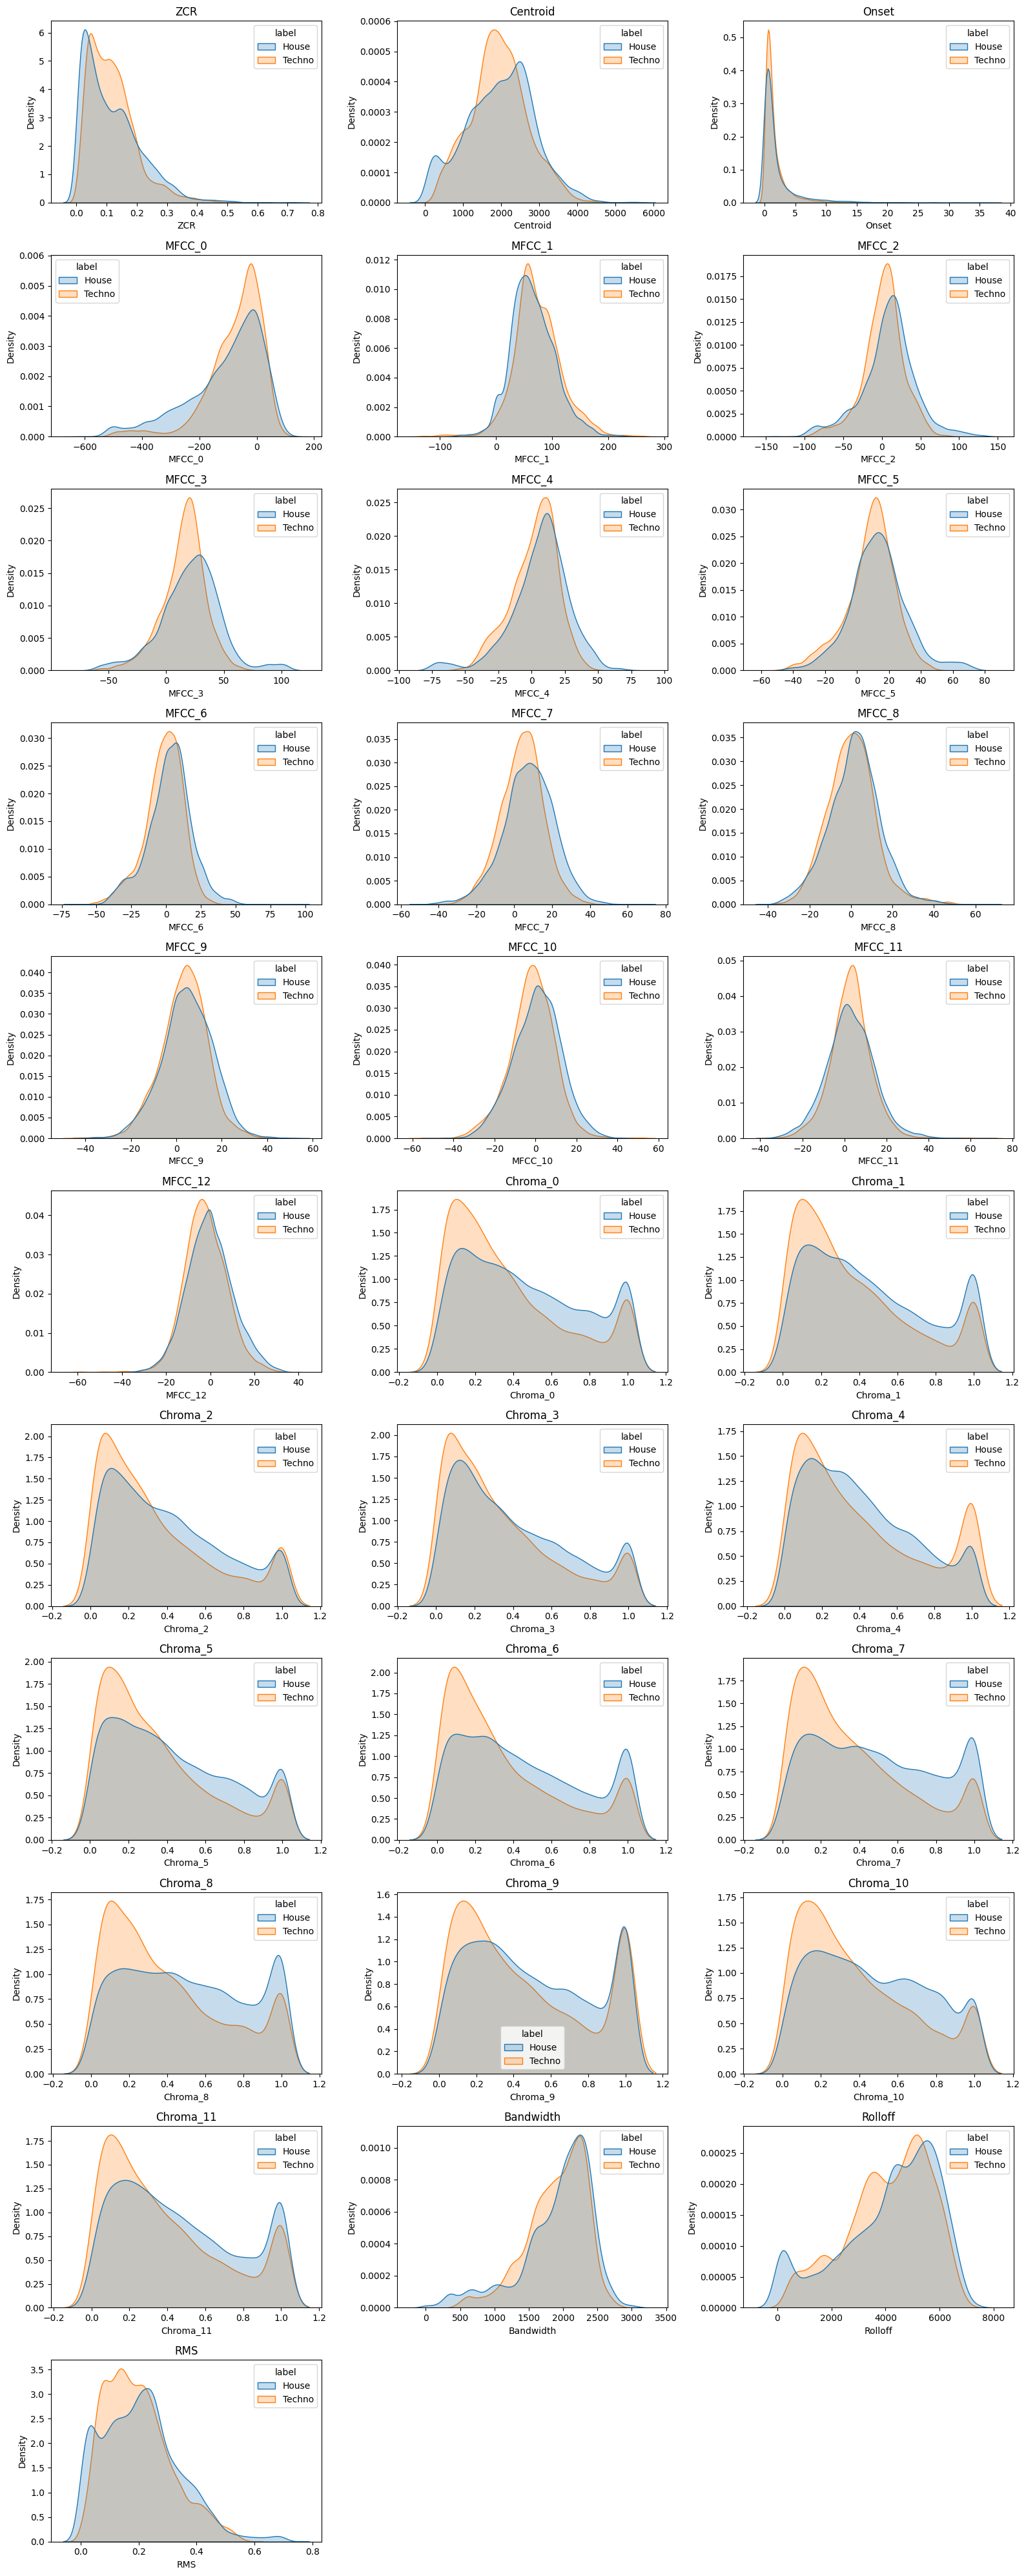

In [29]:
plt.figure(figsize=(16, 40))
for i, feat in enumerate(features_names):
    plt.subplot(11, 3, i + 1)
    sns.kdeplot(data=df_flat_time_features, x=feat, hue="label", common_norm=False, fill=True)
    plt.title(feat)

plt.tight_layout()
plt.show()

### Heatmap comparison nclasses, features
#### Features to exclude based on heatmap: ZCR, MFCC_3, MFCC_4, MFCC_6, Chroma_0, Chroma_2, Chroma_6, Chroma_9, Chroma_10

In [39]:
heatmap_features = [
    'Chroma_7', 'Chroma_8', 'MFCC_0', 'Chroma_6', 'Chroma_0',
    'Chroma_10', 'MFCC_5', 'MFCC_7', 'Chroma_1', 'Chroma_5',
     'Chroma_11', 'MFCC_1'
]

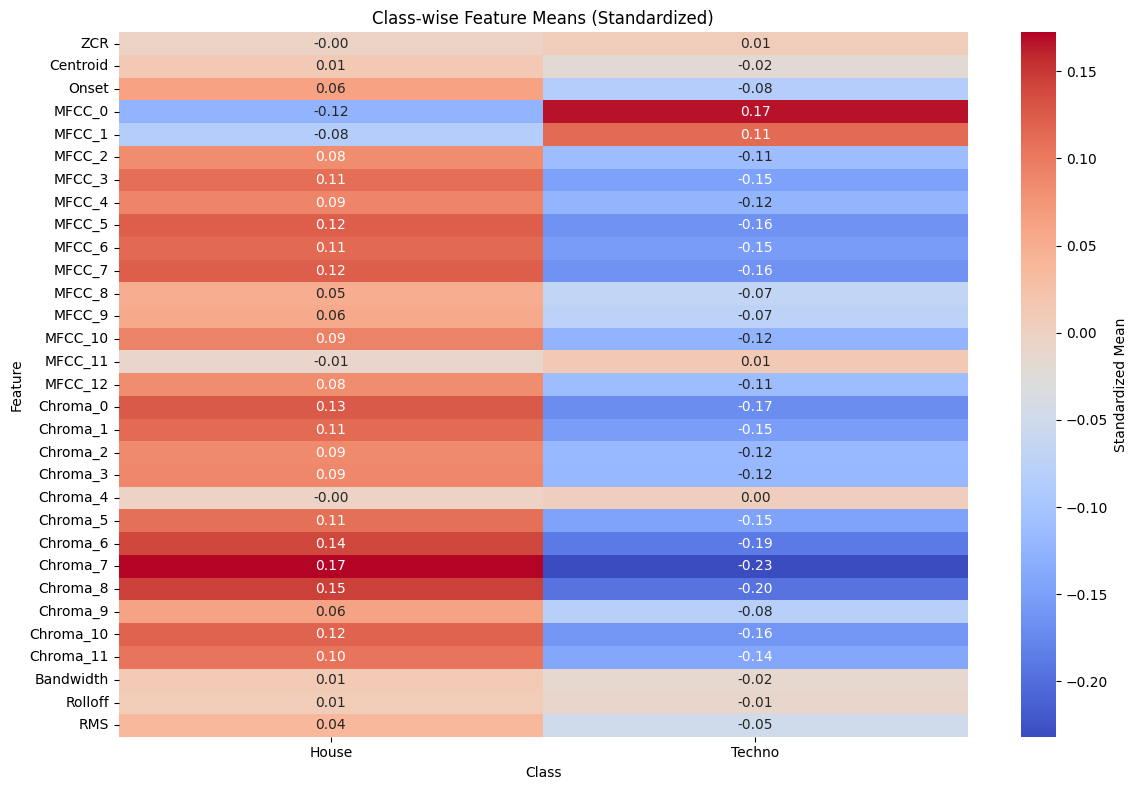

In [40]:
from sklearn.preprocessing import StandardScaler

X_flat_scaled = StandardScaler().fit_transform(X_flat_time)
df_flat = pd.DataFrame(X_flat_scaled, columns=features_names)
df_flat["label"] = y_repeated

# Compute per-class averages (mean over time steps)
df_class_avg = df_flat.groupby("label").mean().T

# Plot heatmap with annotations
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_class_avg,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Standardized Mean"}
)
plt.title("Class-wise Feature Means (Standardized)")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Boxplots with mean over frames
#### zcr, mfcc_5, mfcc_8, mfcc_9, chroma_4, chroma_9

In [42]:
boxplot_features = [
    'MFCC_0', 'Chroma_0', 'Chroma_1', 'Chroma_2', 'Chroma_3',
    'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8'
]

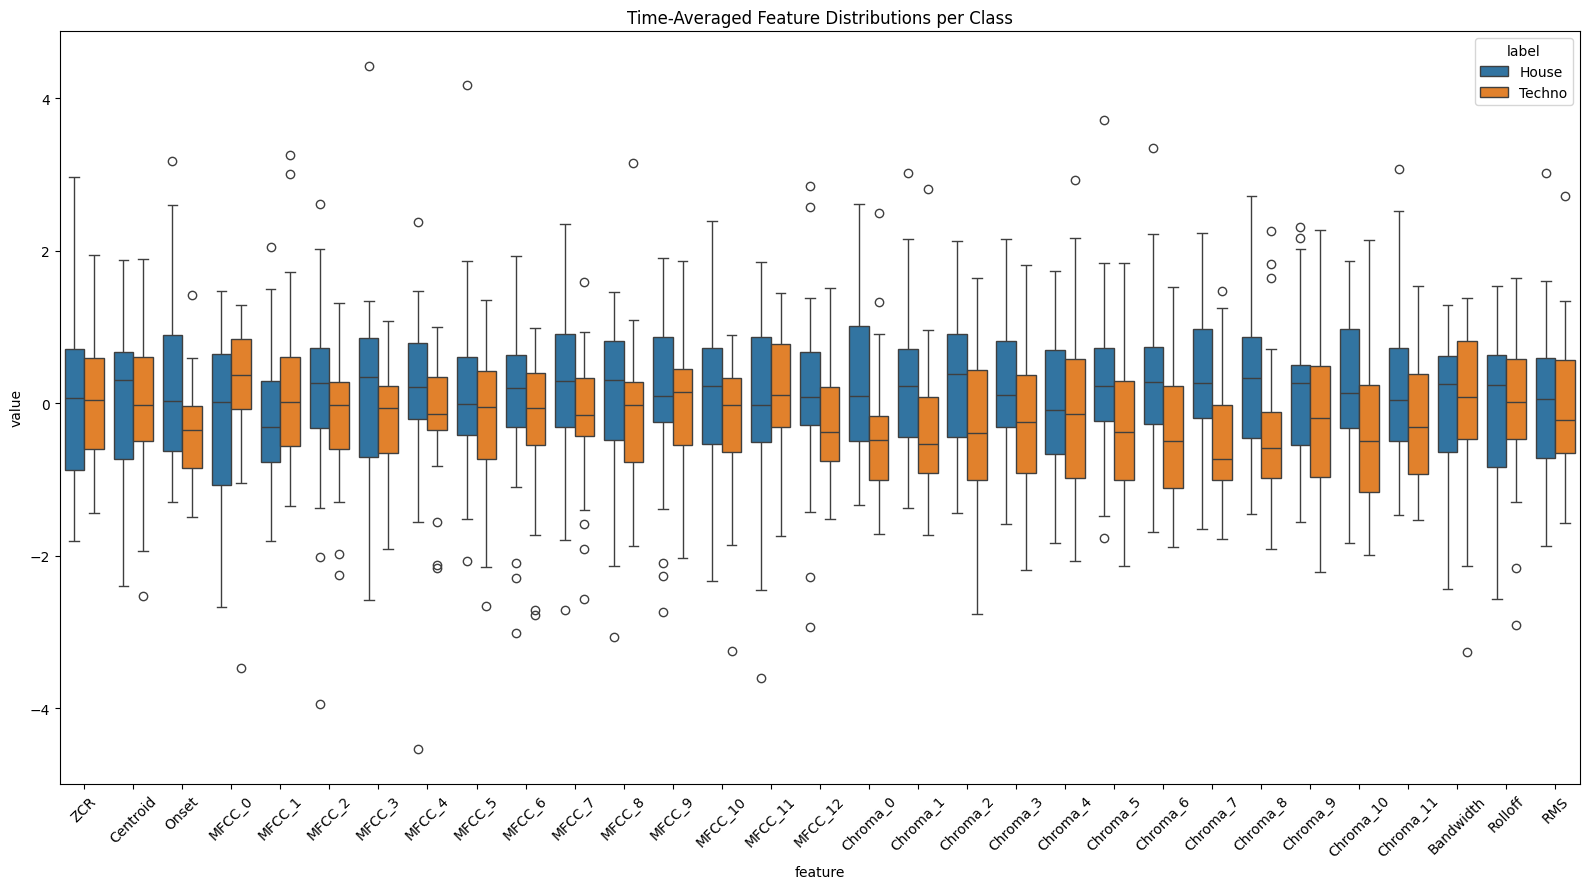

In [41]:
# Mean over time for each instance
X_mean = X.mean(axis=1)  # shape: (n_instances, features)
df_mean = pd.DataFrame(X_mean, columns=features_names)
df_mean["label"] = y_segments

# Standardize for easier comparison
df_scaled = (df_mean[features_names] - df_mean[features_names].mean())/df_mean[features_names].std()
df_scaled["label"] = y_segments

# Melt for seaborn
df_melted = df_scaled.melt(id_vars="label", var_name="feature", value_name="value")

plt.figure(figsize=(16, 9))
sns.boxplot(data=df_melted, x="feature", y="value", hue="label")
plt.xticks(rotation=45)
plt.title("Time-Averaged Feature Distributions per Class")
plt.tight_layout()
plt.show()

### Correlation matrix after aggregating temporal dimension

In [47]:
exclude_features = [
    'ZCR', 'Centroid', 'Onset',  # Poor discrimination
    'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 
    'MFCC_10', 'MFCC_11', 'MFCC_12',  # Poor discrimination + high correlation
    'Chroma_9', 'Chroma_10', 'Chroma_11',  # Weaker discrimination
    'Bandwidth', 'Rolloff', 'RMS'  # Poor discrimination
]

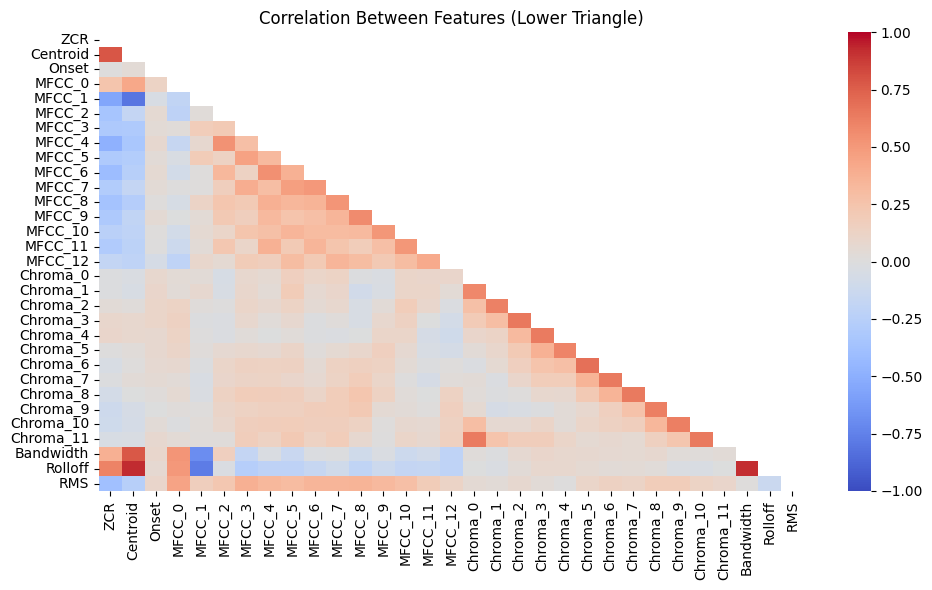

In [ ]:
# Compute correlation matrix (excluding label)
corr = df_flat.drop(columns=['label']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Plot heatmap with mask
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Features (Lower Triangle)")
plt.tight_layout()
plt.show()

### Timeseries-based Feature Discrimination 
#### Based on the timeseries-based plots, bad features for discrimination are: zcr, centroid, mfcc8, mfcc9, mfcc11, mfcc12, chroma2, chroma3, chroma4, chroma5, chroma9, bandwidth, rollfoff, rms --> most useful in case of temporal based ai modeling whatsoever
  
#### Questions: Are those equally useful/bad on statistical models where aggregation happens over frames?
#### What about those features (over time) that differ for only a specific time interval, e.g. last half?

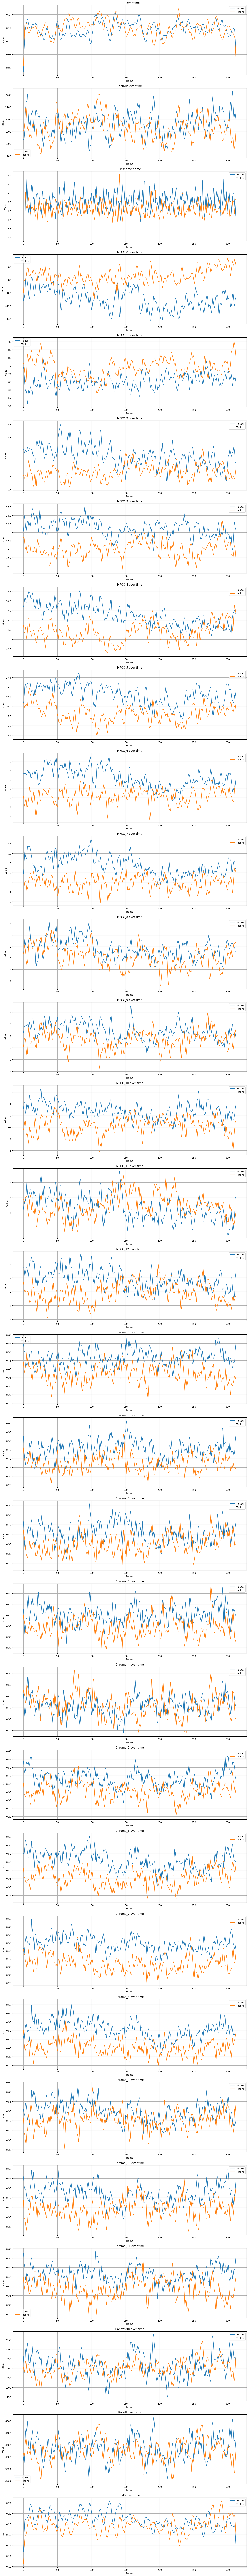

In [50]:
n_features = X.shape[2]
n_frames = X.shape[1]
classes = np.unique(y_segments)

# For each class and feature: compute mean over all instances → (classes, frames, features)
class_trajectories = {}

for cls in classes:
    cls_idx = np.where(y_segments == cls)[0]
    class_trajectories[cls] = X[cls_idx].mean(axis=0)  # shape: (frames, features)

# Plot selected features
selected_features = np.arange(X.shape[-1])
frames = np.arange(n_frames)

plt.figure(figsize=(15, 5 * len(selected_features)))

for i, f_idx in enumerate(selected_features):
    plt.subplot(len(selected_features), 1, i + 1)
    for cls in classes:
        plt.plot(frames,
                 class_trajectories[cls][:, f_idx],
                 label=f'{cls}')
    plt.title(f"{features_names[f_idx]} over time")
    plt.xlabel("Frame")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## AI Modeling

### Encode Labels

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_segments)  # 'house', 'techno' → 0, 1

### Aggregate data by frames dimension --> Dimensionality Reduction

In [52]:
from utils import report_pca_variance
from utils_visual import plot_pca_2d, plot_pca_3d

In [53]:
# Compute segment-wise mean (across time axis)
X_frames_mean = X.mean(axis=1)
X_frames_mean.shape

(68, 31)

### PCA plots for data aggregated across frames

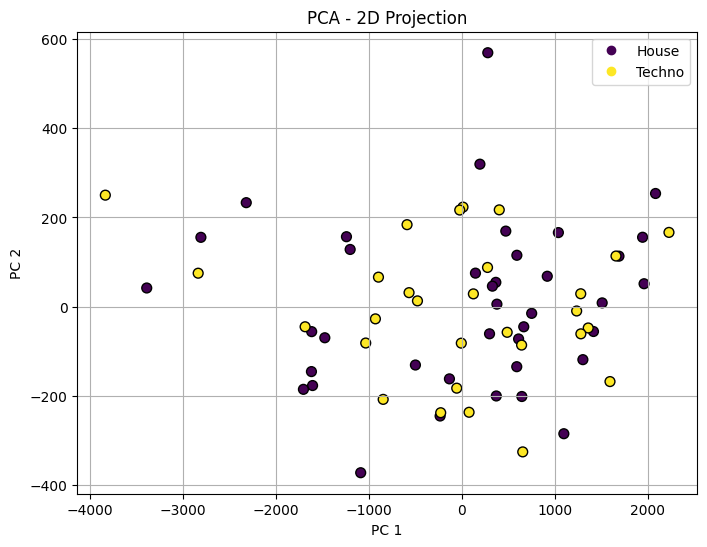

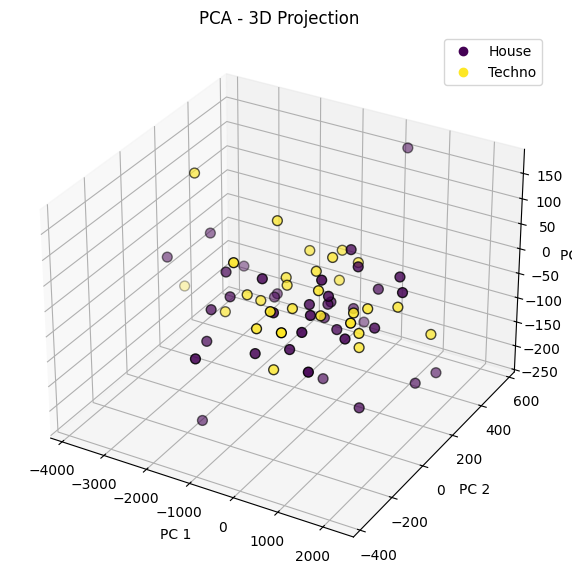

95% variance retained with 1 components.


In [54]:
X_pca2 = plot_pca_2d(X_frames_mean, y_encoded, class_names=le.classes_)
X_pca3 = plot_pca_3d(X_frames_mean, y_encoded, class_names=le.classes_)
n_component, cumvar = report_pca_variance(X_frames_mean, threshold=0.95)

### Train SVM with all features, pca-2D, pca3D, different scalers etc.

In [55]:
from utils import train_model_pipelines


=== MinMax Scaler ===
no_pca: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_2d: F1-score = 0.927 | Accuracy = 0.929 | Best Params = {'model__C': 10, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_95var: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.416 | Accuracy = 0.571 | Best Params = {'model__C': 0.1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}
pca_3d: F1-score = 0.552 | Accuracy = 0.571 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_95var: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}
pca_2d: F1-sc

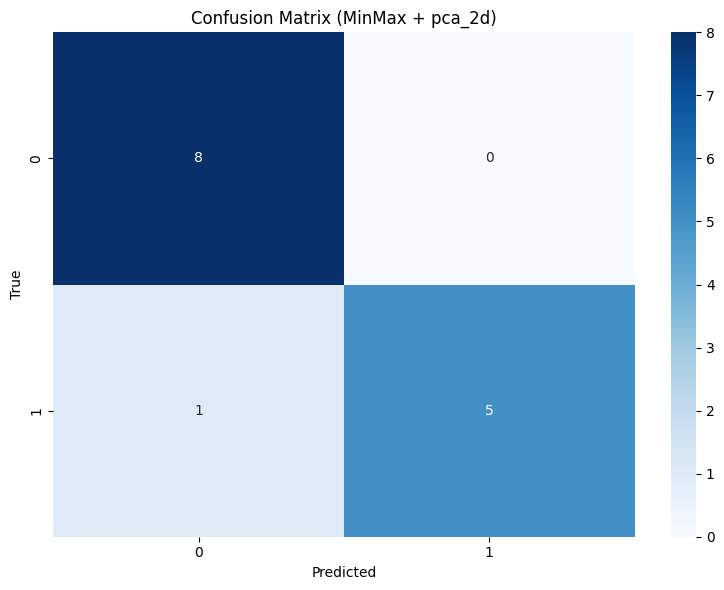

In [56]:
results = train_model_pipelines(X_frames_mean, y_encoded, model_type="svm", test_size=0.2, random_state=SEED)

#### Mini Report: In all scenrarios, PCA2D worked best for SVM using MinMax and RobustScaler. This might be intuitive, since as we show in the pca variance analysis, a single component holds 95% of the dataset variance.

### Train Random Forest


=== MinMax Scaler ===
no_pca: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__max_depth': None, 'model__n_estimators': 200}
pca_2d: F1-score = 0.503 | Accuracy = 0.500 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_95var: F1-score = 0.492 | Accuracy = 0.500 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}

=== Standard Scaler ===
no_pca: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__max_depth': None, 'model__n_estimators': 200}
pca_2d: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_3d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_95var: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__max_depth': None, 'model__n_estimators': 200}

=== Robust Scaler ===
no_

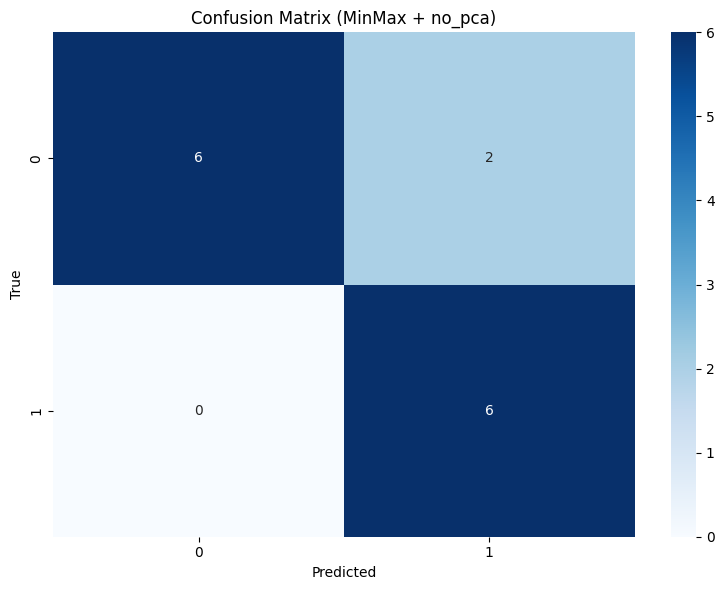

In [57]:
results = train_model_pipelines(X_frames_mean, y_encoded, model_type="rf", test_size=0.2, random_state=SEED)

#### Mini Report: In all scenrarios, No PCA, input features as is, worked best for RF using all 3 classifeirs.

## Flatten the two dimensions and treat those as features

In [58]:
X_flatten = X.reshape(-1, X.shape[1]*X.shape[2])  # flatten ninstances, frames*features
X_flatten.shape

(68, 9703)

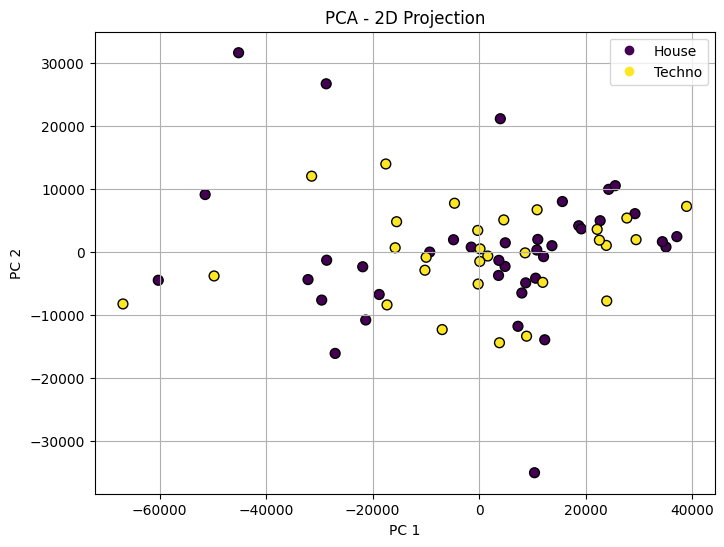

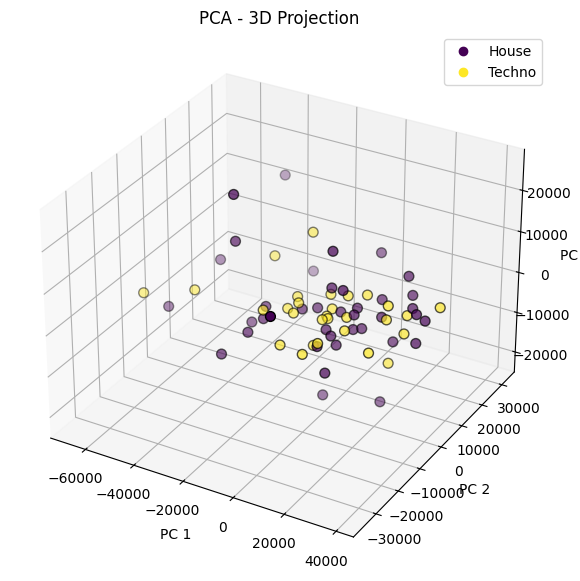

95% variance retained with 34 components.


In [59]:
X_pca2 = plot_pca_2d(X_flatten, y_encoded, class_names=le.classes_)
X_pca3 = plot_pca_3d(X_flatten, y_encoded, class_names=le.classes_)
n_component, cumvar = report_pca_variance(X_flatten, threshold=0.95)

## Training SVM


=== MinMax Scaler ===
no_pca: F1-score = 0.552 | Accuracy = 0.571 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_2d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_3d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_95var: F1-score = 0.558 | Accuracy = 0.643 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}

=== Standard Scaler ===
no_pca: F1-score = 0.552 | Accuracy = 0.571 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_2d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__max_depth': 20, 'model__n_estimators': 100}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__max_depth': None, 'model__n_estimators': 200}
pca_95var: F1-score = 0.671 | Accuracy = 0.714 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}

=== Robust Scaler ===
no_pc

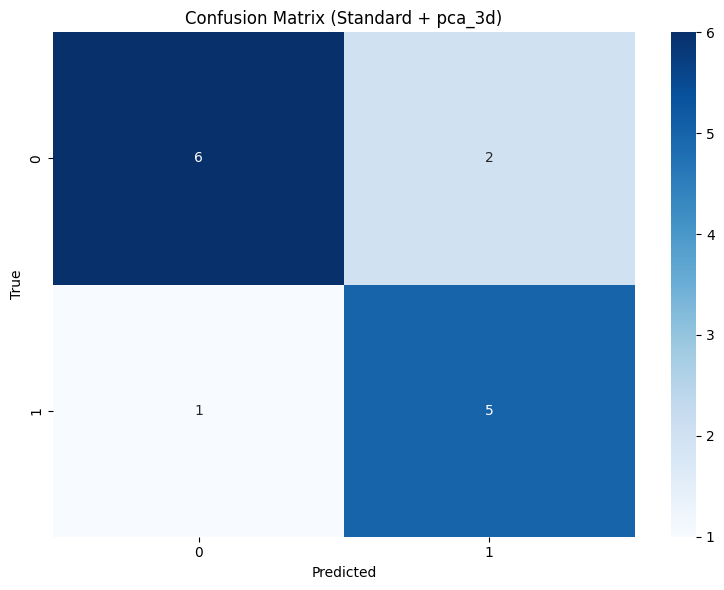

In [60]:
results = train_model_pipelines(X_flatten, y_encoded, model_type="rf", test_size=0.2, random_state=SEED)

#### Mini Report: In all scenrarios, PCA3D worked best for SVM using MinMax scaler

### Train Random Forest


=== MinMax Scaler ===
no_pca: F1-score = 0.552 | Accuracy = 0.571 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_2d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__max_depth': 20, 'model__n_estimators': 200}
pca_95var: F1-score = 0.558 | Accuracy = 0.643 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}

=== Standard Scaler ===
no_pca: F1-score = 0.552 | Accuracy = 0.571 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}
pca_2d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__max_depth': 10, 'model__n_estimators': 200}
pca_3d: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__max_depth': None, 'model__n_estimators': 200}
pca_95var: F1-score = 0.671 | Accuracy = 0.714 | Best Params = {'model__max_depth': None, 'model__n_estimators': 100}

=== Robust Scaler ===
no_pca:

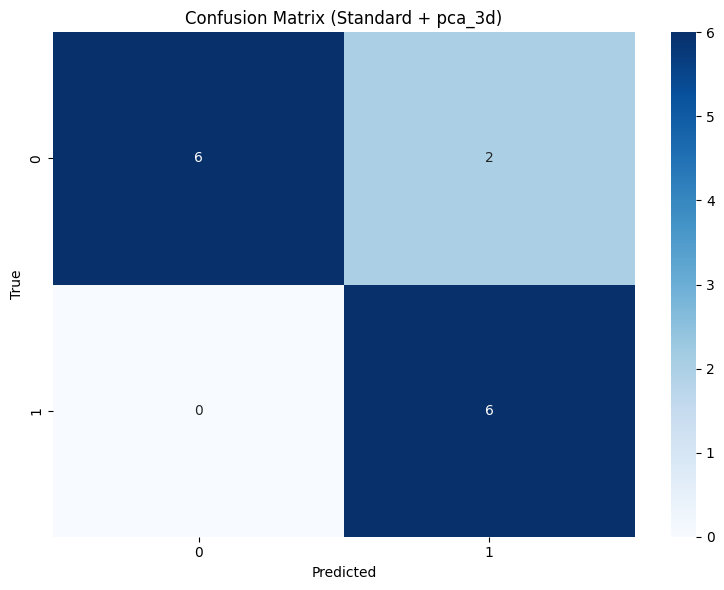

In [61]:
results = train_model_pipelines(X_flatten, y_encoded, model_type="rf", test_size=0.2, random_state=SEED)

#### Mini Report: In all scenrarios, in this trianing scenario, different configurations worked best. there is no specific pattern. The important this is that by flattening the frames and features dimeneions we get worst results with both svm and RF with comparsion to aggregating by the frames dimensions. So, for the rest of the experiments, we will proceed with this configutation to improve the classfiication performances

### Select most important features

In [ ]:
# Based on analysis from various methods, the following features are considered less useful for discrimination:
# 
# From Heatmap:        ZCR, MFCC_3, MFCC_4, MFCC_6, Chroma_0, Chroma_2, Chroma_6, Chroma_9, Chroma_10
# From Boxplots:       ZCR, MFCC_5, MFCC_8, MFCC_9, Chroma_4, Chroma_9
# From Feature plots:  ZCR, Centroid, MFCC_8, MFCC_9, MFCC_11, MFCC_12,
#                      Chroma_2, Chroma_3, Chroma_4, Chroma_5, Chroma_9, Bandwidth, Rolloff, RMS
# From High Correlation (|Spearman| > 0.6):
#                      Centroid, MFCC_1, MFCC_4, MFCC_5, MFCC_6, MFCC_7, MFCC_8, MFCC_9, MFCC_11,
#                      Chroma_3, Chroma_4, Chroma_6, Chroma_7, Chroma_8, Chroma_9, Chroma_10, Chroma_11,
#                      Bandwidth, Rolloff


# Final consolidated set of "not great" features:
# ZCR, Centroid, Bandwidth, Rolloff, RMS,
# MFCC_1, MFCC_3, MFCC_4, MFCC_5, MFCC_6, MFCC_7, MFCC_8, MFCC_9, MFCC_11, MFCC_12,
# Chroma_0, Chroma_2, Chroma_3, Chroma_4, Chroma_5, Chroma_6, Chroma_7, Chroma_8, Chroma_9, Chroma_10, Chroma_11

df_mean.columns

Index(['ZCR', 'Centroid', 'Onset', 'MFCC_0', 'MFCC_1', 'MFCC_2', 'MFCC_3',
       'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10',
       'MFCC_11', 'MFCC_12', 'Chroma_0', 'Chroma_1', 'Chroma_2', 'Chroma_3',
       'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9',
       'Chroma_10', 'Chroma_11', 'Bandwidth', 'Rolloff', 'RMS', 'label'],
      dtype='object')

#### Feature selection and re-training based on the heatmap

[3, 4, 8, 10, 16, 17, 21, 22, 23, 24, 26, 27]
Original shape: (68, 31)
Filtered shape: (68, 12)

=== MinMax Scaler ===
no_pca: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_2d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}
pca_95var: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_95var: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}

=== Robust Scaler ===
no_pca: F1-score = 0.

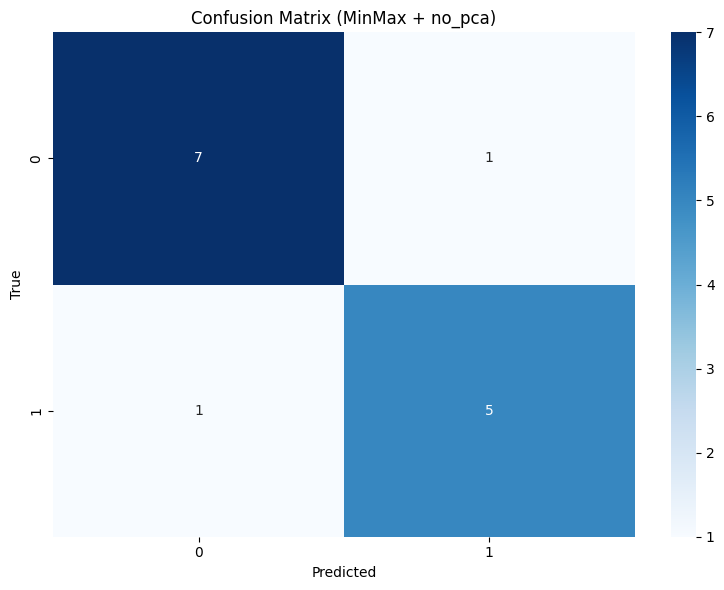

In [65]:
feature_names = df_mean.columns[:-1]  # exclude 'label' if it's in the last column

# Get indices of features to keep (complement)
keep_indices = [i for i, name in enumerate(feature_names) if name in heatmap_features]
print(keep_indices)
# Apply selection to X_frames_mean
X_filtered = X_frames_mean[:, keep_indices]

print("Original shape:", X_frames_mean.shape)
print("Filtered shape:", X_filtered.shape)

results = train_model_pipelines(X_filtered, y_encoded, model_type="svm", test_size=0.2, random_state=SEED)

#### Feature selection and re-training based on the Boxplots

Original shape: (68, 31)
Filtered shape: (68, 10)

=== MinMax Scaler ===
no_pca: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_2d: F1-score = 0.851 | Accuracy = 0.857 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}
pca_3d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_95var: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.416 | Accuracy = 0.571 | Best Params = {'model__C': 0.1, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_95var: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'mo

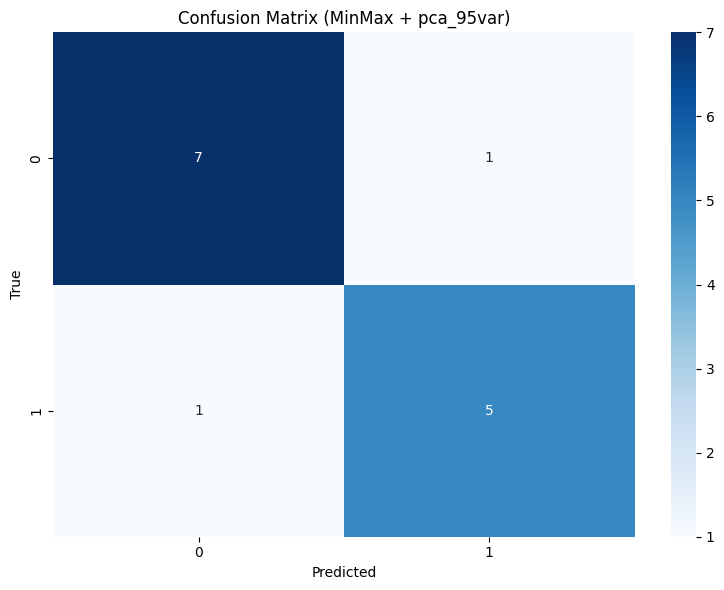

In [66]:
# Get indices of features to keep (complement)
keep_indices = [i for i, name in enumerate(feature_names) if name in boxplot_features]

# Apply selection to X_frames_mean
X_filtered = X_frames_mean[:, keep_indices]

print("Original shape:", X_frames_mean.shape)
print("Filtered shape:", X_filtered.shape)

results = train_model_pipelines(X_filtered, y_encoded, model_type="svm", test_size=0.2, random_state=SEED)

#### Feature selection and re-training based on the temporal observations

Original shape: (68, 31)
Filtered shape: (68, 17)

=== MinMax Scaler ===
no_pca: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_3d: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_95var: F1-score = 0.787 | Accuracy = 0.786 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.767 | Accuracy = 0.786 | Best Params = {'model__C': 10, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_95var: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.702 | Accuracy = 0.714 | Best Params = {'mo

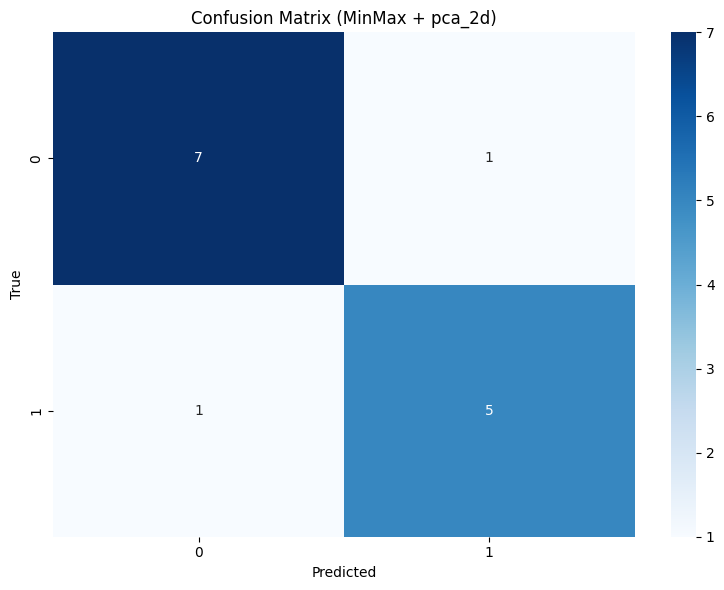

In [68]:
featutes_over_frames = [
    "ZCR", "Centroid", "MFCC_8", "MFCC_9", "MFCC_11", "MFCC_12",
    "Chroma_2", "Chroma_3", "Chroma_4", "Chroma_5",
    "Chroma_9", "Bandwidth", "Rolloff", "RMS"
]
# Get indices of features to keep (complement)
keep_indices = [i for i, name in enumerate(feature_names) if name not in featutes_over_frames]

# Apply selection to X_frames_mean
X_filtered = X_frames_mean[:, keep_indices]

print("Original shape:", X_frames_mean.shape)
print("Filtered shape:", X_filtered.shape)

results = train_model_pipelines(X_filtered, y_encoded, model_type="svm", test_size=0.2, random_state=SEED)

#### Feature selection and re-training based on the correlation matrix

Original shape: (68, 31)
Filtered shape: (68, 13)

=== MinMax Scaler ===
no_pca: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.927 | Accuracy = 0.929 | Best Params = {'model__C': 1, 'model__gamma': 'auto'}
pca_3d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}
pca_95var: F1-score = 0.857 | Accuracy = 0.857 | Best Params = {'model__C': 10, 'model__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}
pca_2d: F1-score = 0.416 | Accuracy = 0.571 | Best Params = {'model__C': 0.1, 'model__gamma': 'scale'}
pca_3d: F1-score = 0.714 | Accuracy = 0.714 | Best Params = {'model__C': 10, 'model__gamma': 'scale'}
pca_95var: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'model__C': 1, 'model__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.782 | Accuracy = 0.786 | Best Params = {'m

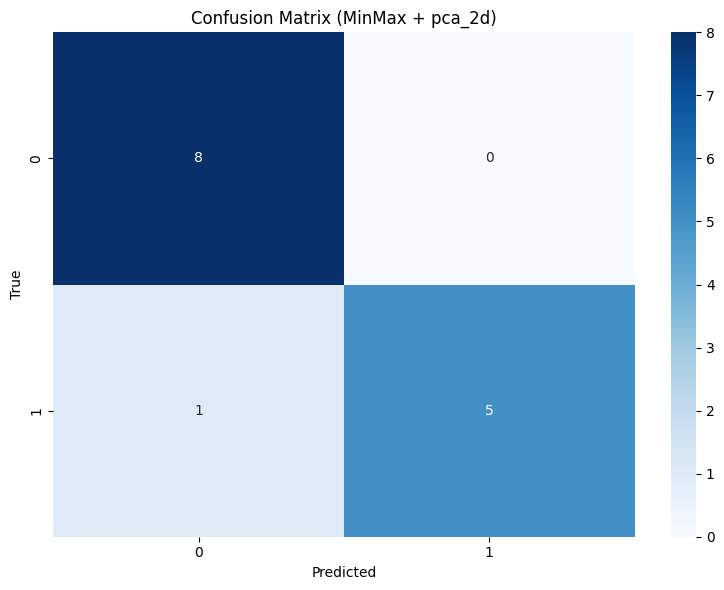

In [67]:
# Get indices of features to keep (complement)
keep_indices = [i for i, name in enumerate(feature_names) if name not in exclude_features]

# Apply selection to X_frames_mean
X_filtered = X_frames_mean[:, keep_indices]

print("Original shape:", X_frames_mean.shape)
print("Filtered shape:", X_filtered.shape)

results = train_model_pipelines(X_filtered, y_encoded, model_type="svm", test_size=0.2, random_state=SEED)